# Import Libraries

In [25]:

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
# machine learning
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve,
    average_precision_score
)

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

#SMOTE
from imblearn.over_sampling import SMOTE


# Load Dataset

In [26]:

df = pd.read_csv("/content/loan_approval_dataset.csv")
df.head()


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


# Data Exploration

Shape: (4269, 13)

Missing values:
 loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

Target distribution:
  loan_status
Approved    2656
Rejected    1613
Name: count, dtype: int64


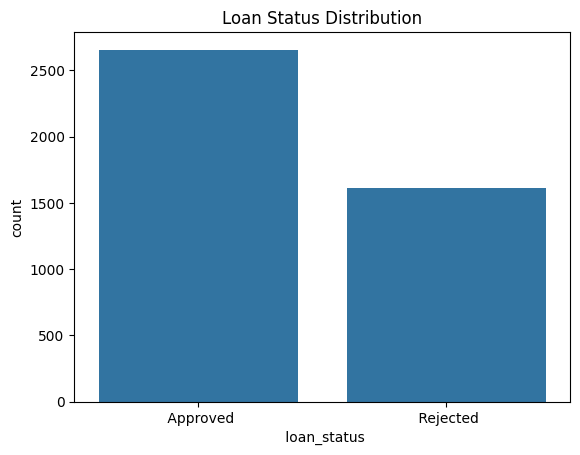

In [27]:
print("Shape:", df.shape)
print("\nMissing values:\n", df.isnull().sum())
print("\nTarget distribution:\n", df[' loan_status'].value_counts())
sns.countplot(data=df, x=" loan_status")
plt.title("Loan Status Distribution")
plt.show()

# **Handle Missing Values **(we can remove this steps "dataset does not have missing values")

In [28]:
# fill missing categorical with mode
for col in df.select_dtypes(include="object").columns:
    df[col].fillna(df[col].mode()[0], inplace=True)

# fill missing numeric with median
for col in df.select_dtypes(include=["int64","float64"]).columns:
    df[col].fillna(df[col].median(), inplace=True)

print("Missing values after handling:\n", df.isnull().sum().sum())


Missing values after handling:
 0


/tmp/ipython-input-64576863.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)
/tmp/ipython-input-64576863.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using '

# Encode Categorical Features

In [29]:
le = LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    df[col] = le.fit_transform(df[col])

df.head()


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,0,0,9600000,29900000,12,778,2400000,17600000,22700000,8000000,0
1,2,0,1,1,4100000,12200000,8,417,2700000,2200000,8800000,3300000,1
2,3,3,0,0,9100000,29700000,20,506,7100000,4500000,33300000,12800000,1
3,4,3,0,0,8200000,30700000,8,467,18200000,3300000,23300000,7900000,1
4,5,5,1,1,9800000,24200000,20,382,12400000,8200000,29400000,5000000,1


# Define Features & Target


In [30]:
X = df.drop(" loan_status", axis=1)
y = df[" loan_status"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


# Balance Data using SMOTE (BONUS)

After SMOTE:  loan_status
1    2125
0    2125
Name: count, dtype: int64


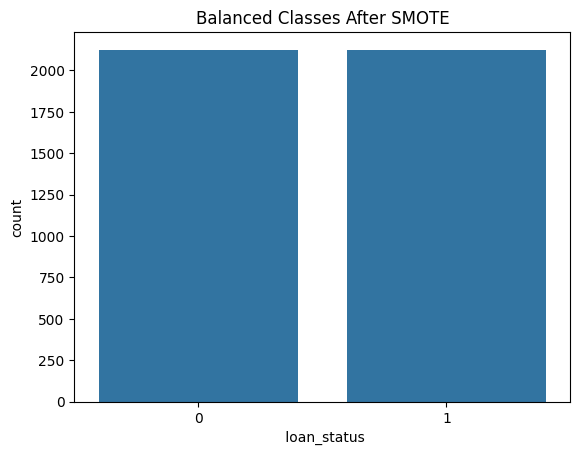

In [37]:
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print("After SMOTE:", y_train.value_counts())
sns.countplot(x=y_train)
plt.title("Balanced Classes After SMOTE")
plt.show()


In [31]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# Train Multiple Models

In [32]:
# define models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
}

# train and evaluate
results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]

    results[name] = {
        "report": classification_report(y_test, y_pred, output_dict=True),
        "auc": roc_auc_score(y_test, y_prob),
        "pred": y_pred,
        "prob": y_prob
    }
    print("="*40)
    print(name)
    print(classification_report(y_test, y_pred))
    print("AUC:", roc_auc_score(y_test, y_prob))


Logistic Regression
              precision    recall  f1-score   support

           0       0.92      0.95      0.94       531
           1       0.92      0.87      0.89       323

    accuracy                           0.92       854
   macro avg       0.92      0.91      0.92       854
weighted avg       0.92      0.92      0.92       854

AUC: 0.97434013748229
Decision Tree
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       531
           1       0.98      0.96      0.97       323

    accuracy                           0.98       854
   macro avg       0.98      0.97      0.97       854
weighted avg       0.98      0.98      0.98       854

AUC: 0.9726784558604886
Random Forest
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       531
           1       0.99      0.96      0.97       323

    accuracy                           0.98       854
   macro avg       0.98      0.98 

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [16:44:02] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       531
           1       0.99      0.97      0.98       323

    accuracy                           0.98       854
   macro avg       0.98      0.98      0.98       854
weighted avg       0.98      0.98      0.98       854

AUC: 0.9987697725536839


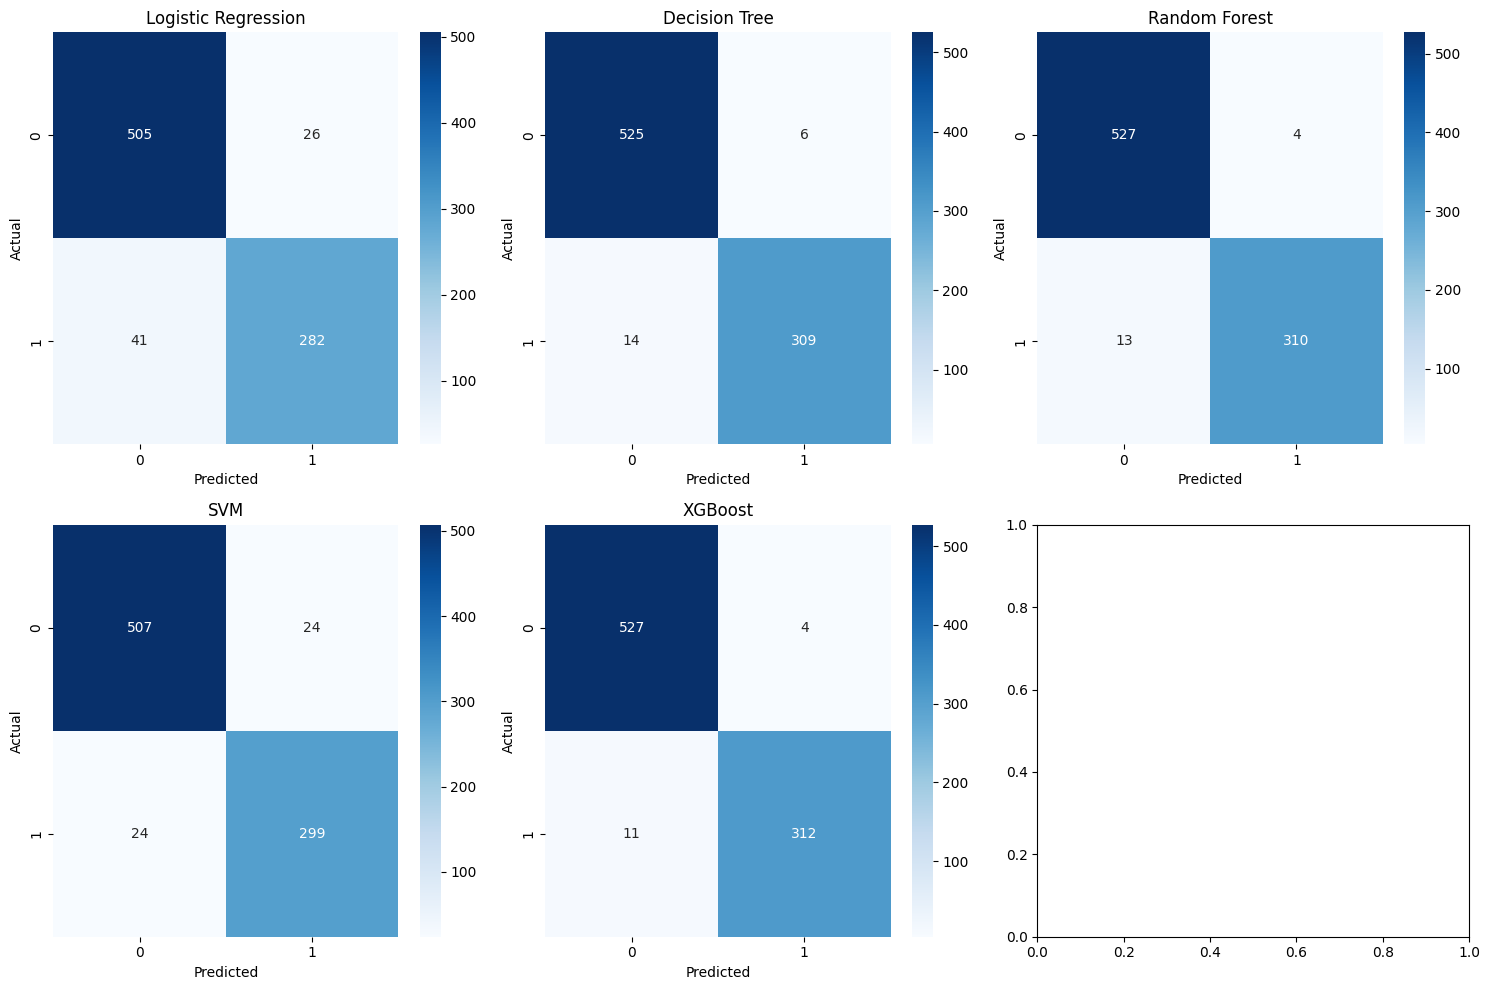

In [33]:
fig, axes = plt.subplots(2, 3, figsize=(15,10))
axes = axes.flatten()

for idx, (name, res) in enumerate(results.items()):
    cm = confusion_matrix(y_test, res["pred"])
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[idx])
    axes[idx].set_title(name)
    axes[idx].set_xlabel("Predicted")
    axes[idx].set_ylabel("Actual")

plt.tight_layout()
plt.show()


# ROC & PR Curves

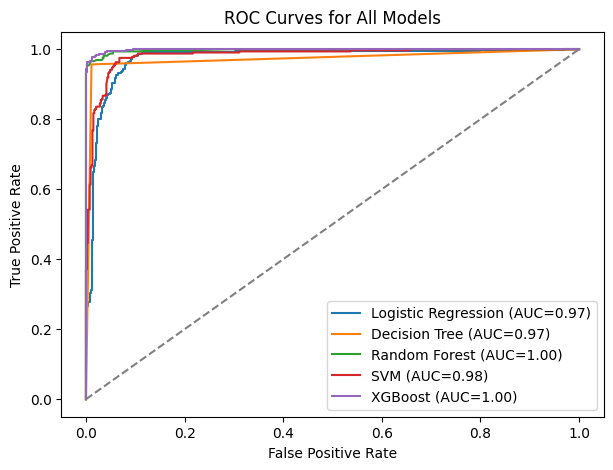

In [34]:
plt.figure(figsize=(7,5))

for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res["prob"])
    plt.plot(fpr, tpr, label=f"{name} (AUC={res['auc']:.2f})")

plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend()
plt.show()


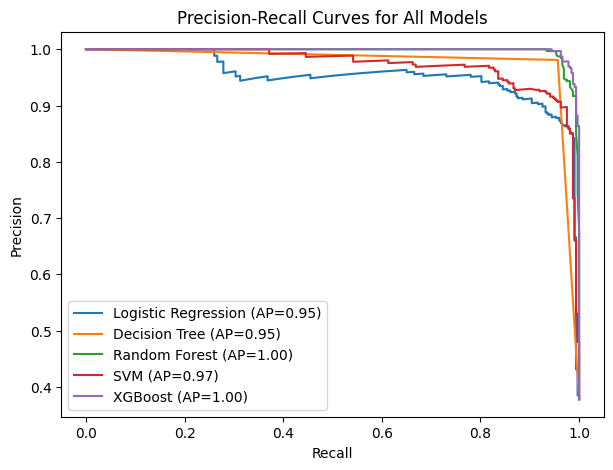

In [35]:
plt.figure(figsize=(7,5))

for name, res in results.items():
    prec, rec, _ = precision_recall_curve(y_test, res["prob"])
    ap = average_precision_score(y_test, res["prob"])
    plt.plot(rec, prec, label=f"{name} (AP={ap:.2f})")

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curves for All Models")
plt.legend()
plt.show()


# Summary

In [36]:
summary = []
for name, res in results.items():
    f1 = res["report"]["1"]["f1-score"]
    precision = res["report"]["1"]["precision"]
    recall = res["report"]["1"]["recall"]
    auc = res["auc"]
    summary.append([name, precision, recall, f1, auc])

summary_df = pd.DataFrame(summary, columns=["Model", "Precision", "Recall", "F1-score", "AUC"])
summary_df.sort_values(by="F1-score", ascending=False)


,Model,Precision,Recall,F1-score,AUC
4,XGBoost,0.987342,0.965944,0.976526,0.998770
2,Random Forest,0.987261,0.959752,0.973312,0.997607
1,Decision Tree,0.980952,0.956656,0.968652,0.972678
3,SVM,0.925697,0.925697,0.925697,0.983226
0,Logistic Regression,0.915584,0.873065,0.893819,0.974340
